In [1]:
import matplotlib
matplotlib.rc('text', usetex=True)

%matplotlib inline

In [2]:
import logging

import matplotlib_venn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

import misc.bio as bio
import misc.latex as latex
import misc.math_utils as math_utils

import riboutils.ribo_utils as ribo_utils

In [3]:
def get_uniprot_nt_lengths(uniprot_file, min_nt_length=0, types=None):
    """ This function parses a file exported from UniProt giving protein
        information. It then filters based on the 'Status' types, and
        finally filters based on the nucleotide lengths of the sequences.
        It returns a list of lengths.
        
        Args:
            uniprot_file (string) : the path to the file
            
            min_nt_length (int) : the minimum length to include in the result
            
            types (None, or list of strings) : the types to keep after
                filtering; or, if None is given, no filtering will be applied
                
            The available types seem to be:
                * 'unreviewed'
                * 'reviewed'
                * 'unreviewed and UniParc'
                * 'reviewed and UniParc'
                * 'partially reviewed and UniParc'
                * 'partially reviewed'
                
        Returns:
            np.array of ints : the lengths (in nucleotides) of the
                proteins remaining after filtering
    """
    uniprot = pd.read_csv(uniprot_file, sep='\t')

    if types is not None:
        m_types = uniprot['Status'].isin(types)
        uniprot = uniprot[m_types]
        
    uniprot_nt_lengths = uniprot['Length'] * 3

    m_uniprot_nt_lengths = uniprot_nt_lengths > min_nt_length
    uniprot_nt_lengths = uniprot_nt_lengths[m_uniprot_nt_lengths]
    return np.array(uniprot_nt_lengths)

In [4]:
def get_orf_lengths(orfs, orf_types):
    m_orf_type = orfs['orf_type'].isin(orf_types)
    lengths = np.array(orfs.loc[m_orf_type, 'orf_len'])
    return lengths

In [5]:
orfs_file = "/prj/grosshans-riboseq/RPF/orf-predictions/early-samples-unique.smooth.predicted-orfs.bed.gz"
orfs = bio.read_bed(orfs_file)
title = "ORF length distributions"
image_name = None # "/data/projects/departments/Christoph_Dieterich/riboseq/orf-coverage.eps"

In [6]:
# read in the ground truth protein lengths
#uniprot_file = "/data/projects/departments/Christoph_Dieterich/riboseq/uniprot-protein-lengths.tab.gz"
uniprot_file = "/genomes/caenorhabditis_elegans/c_elegans-uniref90-proteins.tab.gz"
truth_nt_lengths = get_uniprot_nt_lengths(uniprot_file)
truth_label = 'UniRef90'

In [7]:
orf_lengths = [ get_orf_lengths(orfs, ribo_utils.orf_type_labels_mapping[label]) 
                   for label in ribo_utils.orf_type_labels]

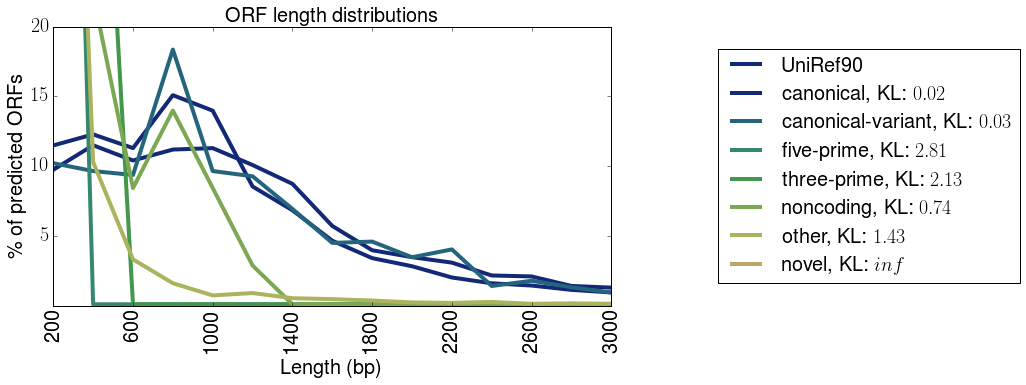

In [9]:
prediction_labels = [latex.get_latex_safe_string(l) for l in ribo_utils.orf_type_labels]
prediction_lengths_list = orf_lengths
#prediction_lengths_list = [bf_lengths, chisq_lengths]
#prediction_labels = ['BF', r'$\chi^2$']

# input: truth_nt_lengths (array-like)
#        prediction_lengths_list (list of array-likes)
#        truth_label (string)
#        prediction_labels (list of array-likes)
#
# if truth_nt_lengths is not defined, then the KL-divergence calculations
# will be skipped (and it will not be shown)

fontsize = 20
legend_fontsize = 20
title_fontsize = 20
linewidth = 4

# plot the empirical distribution of ORF lengths
hist_min = 200
hist_max = 5250
hist_step = 200
hist_range = (hist_min, hist_max)
hist_bins = np.arange(hist_min, hist_max, hist_step)

if truth_nt_lengths is not None:
    truth_hist, _ = np.histogram(truth_nt_lengths, bins=hist_bins, range=hist_range, density=True)
else:
    truth_hist = None
    
prediction_hists = []
for prediction_lengths in prediction_lengths_list:
    prediction_hist, _ = np.histogram(prediction_lengths, bins=hist_bins, range=hist_range, density=True)
    prediction_hists.append(prediction_hist)

# now, normalize the histograms
if truth_hist is not None:
    truth_hist = truth_hist / np.sum(truth_hist)
    truth_hist += 1e-3
    
for i, prediction_hist in enumerate(prediction_hists):
    prediction_hists[i] = prediction_hist / np.sum(prediction_hist)
    prediction_hists[i] += 1e-3

kls = []
if truth_hist is not None:
    for i, prediction_hist in enumerate(prediction_hists):
        kl = math_utils.calculate_symmetric_kl_divergence(truth_hist, prediction_hist, scipy.stats.entropy)
        kls.append(kl)
        
        # and update the label
        prediction_labels[i] = '{}, KL: ${:.2f}$'.format(prediction_labels[i], kl)
        
if truth_hist is not None:
    truth_hist = 100 * truth_hist
    
for i, prediction_hist in enumerate(prediction_hists):
    prediction_hists[i] *= 100

fig, ax = plt.subplots(figsize=(10,5))

cm = plt.cm.gist_earth

x = np.arange(len(hist_bins)-1)

truth_cm_offset = 0.1
if truth_hist is not None:
    color = cm(truth_cm_offset)
    ax.plot(x, truth_hist, label=truth_label, linewidth=linewidth, color=color)
    
color_range = 1 - 2*truth_cm_offset
for i, prediction_hist in enumerate(prediction_hists):
    color = i / len(prediction_hists) * color_range
    color += truth_cm_offset
    color = cm(color)
    ax.plot(x, prediction_hist, label=prediction_labels[i], linewidth=linewidth, color=color)

ax.set_xlabel('Length (bp)', fontsize=fontsize)
ax.set_ylabel('\% of predicted ORFs', fontsize=fontsize)
ax.set_title(title, fontsize=fontsize)

ax.set_xticks(x[::2])
ax.set_xticklabels(hist_bins[::2], fontsize=fontsize, rotation=90)

ax.set_ylim((0, 20))
ax.set_xlim((0, len(hist_bins)))

# hide the "0" tick label
yticks = ax.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)

# chop off everything from 3000 on
index_of_3000 = 14
ax.set_xlim((0, index_of_3000))
#ax.set_xlim((0, len(uniprot_hist)-1))

ax.legend(loc='center right', fontsize=legend_fontsize, bbox_to_anchor=(1.75,0.5))
ax.tick_params(axis='both', which='major', labelsize=fontsize)

if image_name is not None:
    fig.tight_layout()
    fig.savefig(image_name)

In [29]:
min_signal = 10
min_bf_mean = 5
max_bf_var = 2
min_length = 20
chisq_alpha = 0.01

bf = bio.read_bed(bf_file)

orf_types = None # ['noncoding', 'canonical', 'canonical_truncated', 'within',
#       'three_prime', 'suspect_overlap', 'three_prime_overlap',
#       'five_prime', 'canonical_extended', 'five_prime_overlap']

if orf_types is not None:
    m_orf_type = bf['orf_type'].isin(orf_types)
    bf_filtered = bf[m_orf_type]
else:
    bf_filtered = bf

longest_orfs, bf_orfs, chisq_orfs = rpbp.rpbp_utils.get_predicted_orfs(bf_filtered, 
                                                       min_signal=min_signal, 
                                                       min_bf_mean=min_bf_mean, 
                                                       max_bf_var=max_bf_var, 
                                                       min_length=min_length,
                                                       chisq_alpha=chisq_alpha)

bf_lengths = bf_orfs.apply(bio.get_bed_12_feature_length, axis=1)
chisq_lengths = chisq_orfs.apply(bio.get_bed_12_feature_length, axis=1)